ML4HC_Project01_Code:
Part 2


In [1]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#install kaggle
! pip install kaggle

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# make tmp kaggle folder, add json, allow
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/ETH/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# download and unzip dataset
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [6]:
#load dataset paths
#have to store lables here..
data_dir = '/content/chest_xray/train/NORMAL/'
train_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
train_normal = [data_dir + path for path in train_normal]
data_dir = '/content/chest_xray/train/PNEUMONIA/'
train_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
train_pneumonia = [data_dir + path for path in train_pneumonia]
train = train_normal + train_pneumonia

data_dir = '/content/chest_xray/val/NORMAL/'
val_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
val_normal = [data_dir + path for path in val_normal]
data_dir = '/content/chest_xray/val/PNEUMONIA/'
val_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
val_pneumonia = [data_dir + path for path in val_pneumonia]
val = val_normal + val_pneumonia

data_dir = '/content/chest_xray/test/NORMAL/'
test_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
test_normal = [data_dir + path for path in test_normal]
data_dir = '/content/chest_xray/test/PNEUMONIA/'
test_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
test_pneumonia = [data_dir + path for path in test_pneumonia]
test = test_normal + test_pneumonia

In [42]:
# to normalize to [0,1]
class normalize(object):
    def __call__(self, sample):
        image, label = sample
        return image.float() / torch.max(image), label #devide by max pixel

def get_data(path):
    # def transforms
    transform = transforms.Compose([
        transforms.Resize((200, 200)),  # resize
        transforms.ToTensor(),           # to PyTorch tensors
        #normalize()                        # normalize to [0, 1] >> information in absolut value
    ])

    # load dataset with transforms
    dataset = datasets.ImageFolder(root=path, transform=transform)

    # print labels and images
    #for images, labels in dataloader:
    #    print(images.shape)
    #    print(labels)

    return dataset

In [43]:
# loading dataset
train_dataset = get_data('/content/chest_xray/train')
val_dataset = get_data('/content/chest_xray/val')
test_dataset = get_data('/content/chest_xray/test')

#to dataloader
batch = 32
train = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
val = torch.utils.data.DataLoader(val_dataset, batch_size=batch, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)

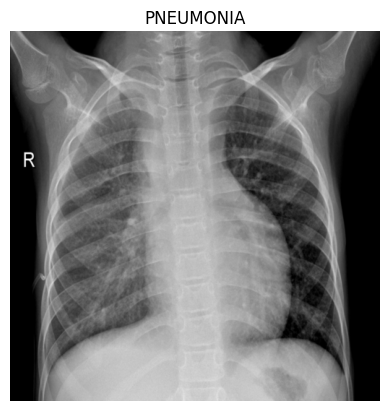

In [9]:
## Plotting one example
# get next image
images, labels = next(iter(train))

# to numpy
image = images[0].numpy()
label = labels[0].item()

# convert tensor shape (channels, height, width) to (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# def classes
classes = ['NORMAL', 'PNEUMONIA']

# plot
plt.imshow(image)
plt.title(classes[label])
plt.axis('off')
plt.show()

In [10]:
# descriptive stats

In [11]:
## Setup model
# load  pre-trained ResNet model
model = models.resnet50(pretrained=True)

# freeze grad
for param in model.parameters():
    param.requires_grad = False

# add last linear layer with sigmoid activation for 0 = normal, 1 = pneumonia
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 1), nn.Sigmoid())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# train the model
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train:
        images, labels = images.to(device), labels.to(device).to(torch.float32)
        optimizer.zero_grad()
        output = loss(model(images).squeeze(), labels)
        output.backward()
        optimizer.step()
        running_loss += output.item() * images.size(0)

    epoch_loss = running_loss / len(train)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 9.7397
Epoch 2/10, Loss: 6.0243
Epoch 3/10, Loss: 5.4697
Epoch 4/10, Loss: 5.4015
Epoch 5/10, Loss: 4.6103
Epoch 6/10, Loss: 4.4780
Epoch 7/10, Loss: 4.3244
Epoch 8/10, Loss: 4.1605
Epoch 9/10, Loss: 3.8775
Epoch 10/10, Loss: 3.6884


In [23]:
torch.save(model.state_dict(), 'trained_model_240414.pth')
#model_save_name = 'resnet50_model_trained.pt'
#path = F"/content/gdrive/'My Drive'/{model_save_name}"
#torch.save(model.state_dict(), path)

In [45]:
# Evaluate the model on the validation set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.5000


In [44]:
model(images.to(device))

tensor([[0.8366],
        [0.9819],
        [0.9994],
        [0.8039],
        [0.3157],
        [0.8321],
        [0.9497],
        [0.9991],
        [0.9985],
        [0.9964],
        [0.9899],
        [0.9984],
        [0.9936],
        [0.9991],
        [0.9457],
        [0.9287]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Integrated Gradients

In [28]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [47]:
val_dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: /content/chest_xray/val
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [61]:
from captum.attr import IntegratedGradients
target_class_index = 1
source = val_dataset

# to torch
img_tensor = torch.stack([sample[0] for sample in source])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor.to(device)
# label_tensor = torch.tensor([sample[1] for sample in source])

# reduce dimentions
#img_tensor.squeeze(3)

ig = IntegratedGradients(model)
attributions, approximation_error = ig.attribute(img_tensor, target=target_class_index, return_convergence_delta=True)

output

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Grad-CAM

https://github.com/jacobgil/pytorch-grad-cam

In [62]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38071 sha256=896e541b500dd45128a082909c05d53eb9b5abed9d2bc2d4b42e601d321d562b
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


In [70]:
target_layers = [model.layer4[-1]]

# input
#images, labels = next(iter(val))
#input_tensor = images
source = val_dataset
input_tensor = torch.stack([sample[0] for sample in source])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor.to(device)

# CAM object
cam = GradCAM(model=model, target_layers=target_layers)

# target
targets = [ClassifierOutputTarget(1)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# example with one img
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# model outputs
model_outputs = cam.outputs


IndexError: index 1 is out of bounds for dimension 0 with size 1

Data Randomization Test